<a href="https://colab.research.google.com/github/mobius29er/AIML_Class/blob/main/usedCarAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

Business Goal:

The used car dealership wants to understand what makes some used cars more valuable than others, so they can make better inventory and pricing decisions.

Task:

We aim to build a predictive regression model that estimates a car’s resale price based on its features (e.g., make, model, year, mileage, condition). This model will help identify the attributes most strongly correlated with higher or lower vehicle prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### **Collect Initial Data:**

In [ ]:
df = pd.read_csv('data/vehicles.csv')
# Initial Data Collection Report
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 406309 rows and 18 columns.


### **Describe Data:**

In [ ]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [ ]:
# Data types
print("\nColumn Data Types:\n")
print(df.dtypes)


Column Data Types:

id                int64
region           object
price           float64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object


In [ ]:
print("\nUnique Values Per Column:\n")
print(df.nunique().sort_values(ascending=False))


Unique Values Per Column:

id              406309
VIN             112928
odometer        101351
model            28547
price            15183
region             387
year               114
state               49
manufacturer        42
type                13
paint_color         12
cylinders            8
title_status         6
condition            6
fuel                 5
size                 4
drive                3
transmission         3
dtype: int64


In [ ]:
print("\nDataset Shape:\n")
print(df.shape)


Dataset Shape:

(406309, 18)


### **Explore Data:**

In [ ]:
# Summary for numerical features
df.describe()

# Summary for categorical features (top 10)
df.select_dtypes(include='object').describe().T.head(10)


,count,unique,top,freq
region,406309,387,columbus,3608
manufacturer,389461,42,ford,67471
model,401235,28547,f-150,7625
condition,240834,6,good,115764
cylinders,236995,8,6 cylinders,89751
fuel,403491,5,gas,338751
title_status,398711,6,clean,385786
transmission,403844,3,automatic,319855
VIN,252039,112928,1FMJU1JT1HEA52352,247
drive,280840,3,4wd,123124


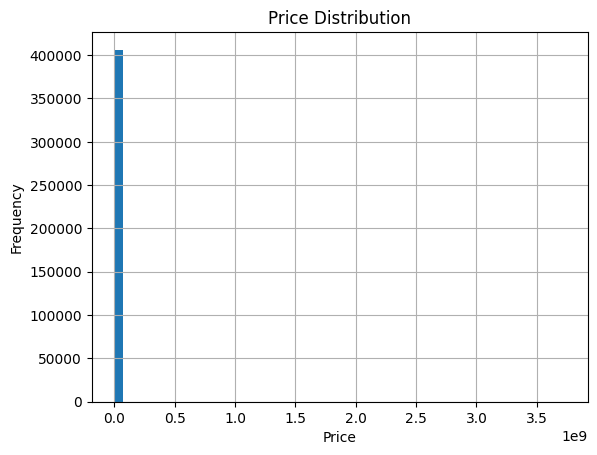

In [ ]:
# Histograms of key numeric fields
df['price'].hist(bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate stats
min_price = df['price'].min()
max_price = df['price'].max()
median_price = df['price'].median()
mean_price = round(df['price'].mean())  # Rounded since price is in whole dollars

# Frequency lookup
min_freq = df['price'].value_counts().get(min_price, 0)
max_freq = df['price'].value_counts().get(max_price, 0)
median_freq = df['price'].value_counts().get(median_price, 0)
mean_freq = df['price'].value_counts().get(mean_price, 0)

# Display results
print(f"Minimum Price: ${min_price:,} (Frequency: {min_freq})")
print(f"Maximum Price: ${max_price:,} (Frequency: {max_freq})")
print(f"Median Price:  ${median_price:,} (Frequency: {median_freq})")
print(f"Mean Price:    ${mean_price:,} (Frequency: {mean_freq})")

# Frequency table: top 10 most common prices
print("\nTop 10 Most Frequent Price Values:")
print(df['price'].value_counts().head(10))


Minimum Price: $0.0 (Frequency: 31873)
Maximum Price: $3,736,928,711.0 (Frequency: 2)
Median Price:  $13,900.0 (Frequency: 845)
Mean Price:    $78,048 (Frequency: 0)

Top 10 Most Frequent Price Values:
price
0.0        31873
6995.0      3052
7995.0      3031
8995.0      2763
9995.0      2751
4500.0      2674
5995.0      2645
29990.0     2596
3500.0      2595
6500.0      2503
Name: count, dtype: int64


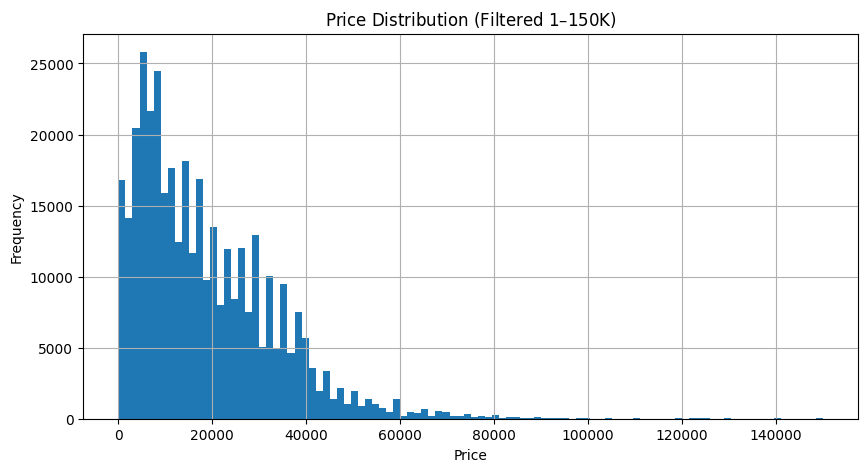

In [ ]:
# Filter out unrealistic prices
df_filtered = df[(df['price'] >= 1) & (df['price'] <= 150000)]

# Replot histogram
plt.figure(figsize=(10, 5))
df_filtered['price'].hist(bins=100)
plt.title('Price Distribution (Filtered $1–$150K)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

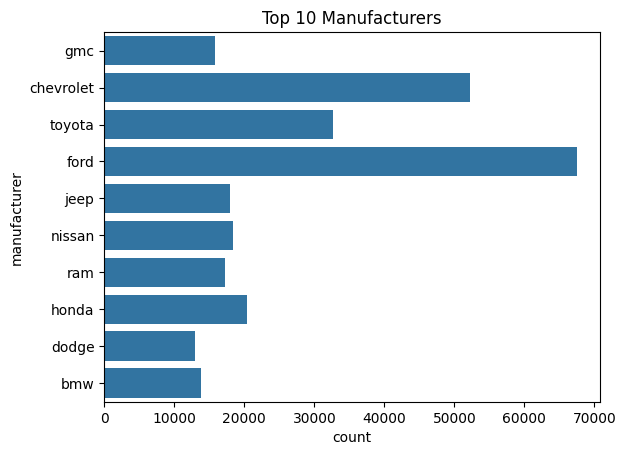

In [ ]:
# Countplot for top manufacturers
top_makes = df['manufacturer'].value_counts().nlargest(10).index
sns.countplot(y='manufacturer', data=df[df['manufacturer'].isin(top_makes)])
plt.title('Top 10 Manufacturers')
plt.show()

### **Verify Data**

In [ ]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
size                 290418  71.477127
cylinders            169314  41.671240
condition            165475  40.726393
VIN                  154270  37.968640
drive                125469  30.880192
paint_color          122913  30.251114
type                  88422  21.762255
manufacturer          16848   4.146598
title_status           7598   1.870005
model                  5074   1.248803
odometer               4162   1.024344
fuel                   2818   0.693561
transmission           2465   0.606681
year                   1113   0.273929
price                     1   0.000246
state                     1   0.000246
region                    0   0.000000
id                        0   0.000000


In [ ]:
# Duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Outlier boundaries (basic)
print("Price range:", df['price'].min(), "to", df['price'].max())

Duplicate Rows: 0
Price range: 0.0 to 3736928711.0


In [ ]:
# Replace '0' VINs with NaN
df['VIN'] = df['VIN'].replace('0', np.nan)

# Filter out placeholder-style VINs that start with '000000'
df = df[~df['VIN'].astype(str).str.startswith('000000')]

# Drop missing VINs
df = df[df['VIN'].notnull()]

# Drop duplicate VINs (same VIN appearing more than once)
df = df.drop_duplicates(subset='VIN', keep='first')

# Re-check final valid VIN stats
valid_vins = df[df['VIN'].notnull()]
duplicate_vins = valid_vins['VIN'].duplicated().sum()

print(f"Valid (non-missing and non-placeholder) VINs: {valid_vins.shape[0]:,}")
print(f"Duplicate VINs (after cleanup): {duplicate_vins:,}")

# Display a few real duplicate examples
if duplicate_vins > 0:
    print("\nSample duplicated VIN entries:")
    display(valid_vins[valid_vins['VIN'].duplicated(keep=False)].sort_values('VIN').head(10))


Valid (non-missing and non-placeholder) VINs: 112,890
Duplicate VINs (after cleanup): 0


In [ ]:
# Check how many rows filtered
print("Original dataset rows: 426,880")
print(f"Remaining rows after VIN cleanup: {df.shape[0]}")

# Show how many were dropped
dropped = 426880 - df.shape[0]
print(f"Total rows dropped: {dropped:,} (~{dropped / 426880:.2%})")


Original dataset rows: 426,880
Remaining rows after VIN cleanup: 112890
Total rows dropped: 313,990 (~73.55%)


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [ ]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('manufacturer')
list_column_options('model')
list_column_options('condition')
list_column_options('cylinders')
list_column_options('fuel')
list_column_options('drive')
list_column_options('paint_color')
list_column_options('transmission')
list_column_options('type')
list_column_options('title_status')
list_column_options('size')



Unique value counts for 'manufacturer':

manufacturer
ford               17847
chevrolet          13348
toyota              9825
honda               6437
nissan              5877
jeep                5295
ram                 4412
gmc                 4087
bmw                 3995
dodge               3593
hyundai             3383
mercedes-benz       3301
subaru              3155
NaN                 2915
kia                 2876
volkswagen          2599
lexus               2276
audi                2014
cadillac            1843
chrysler            1757
mazda               1557
buick               1444
acura               1403
infiniti            1242
lincoln              972
volvo                850
mitsubishi           800
rover                703
mini                 688
pontiac              459
porsche              453
jaguar               340
saturn               242
mercury              238
fiat                 214
tesla                185
alfa-romeo           155
harley-davidson     

In [ ]:
# Drop only truly unnecessary columns if they exist
columns_to_drop = ['id', 'size', "VIN"]
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Fill missing categorical columns
fill_unknown = ['condition', 'cylinders', 'paint_color', 'drive', 'type',
                'title_status', 'manufacturer', 'fuel', 'transmission', 'model']
df[fill_unknown] = df[fill_unknown].fillna('unknown')

# Drop rows where critical numeric fields are missing
df = df[df['year'].notnull()]
df = df[df['odometer'].notnull()]

In [ ]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
region                    0        0.0
price                     0        0.0
year                      0        0.0
manufacturer              0        0.0
model                     0        0.0
condition                 0        0.0
cylinders                 0        0.0
fuel                      0        0.0
odometer                  0        0.0
title_status              0        0.0
transmission              0        0.0
drive                     0        0.0
type                      0        0.0
paint_color               0        0.0
state                     0        0.0


### Step: Clean Manufacturer Names

- Merged `'rover'` and `'land rover'` into a single `'land rover'` category
- Dropped 2,166 entries labeled as `'unknown'` since manufacturer is essential for dealership pricing analysis


In [ ]:
df['manufacturer'] = df['manufacturer'].replace('rover', 'land rover')
df = df[df['manufacturer'] != 'unknown']

### Step: Clean 'condition' Field

- Dropped 10 `salvage` listings — not suitable for dealership inventory
- Retained `unknown` condition for now (43,693 rows), as these listings still contain useful data like price, mileage, and brand which we will utilize to provide recomendations based off of since it can be subjective anyways.

In [ ]:
df = df[df['condition'] != 'salvage']

In [ ]:
# Count missing values
print("\nMissing Values (Count and %):\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df)


Missing Values (Count and %):

              Missing Count  Missing %
region                    0        0.0
price                     0        0.0
year                      0        0.0
manufacturer              0        0.0
model                     0        0.0
condition                 0        0.0
cylinders                 0        0.0
fuel                      0        0.0
odometer                  0        0.0
title_status              0        0.0
transmission              0        0.0
drive                     0        0.0
type                      0        0.0
paint_color               0        0.0
state                     0        0.0


In [ ]:
# Explore sub-$1000 prices
cheap_cars = df[df['price'] < 1000]
print("Total listings under $1000:", cheap_cars.shape[0])
print(cheap_cars['price'].describe())
print("\nMost common low price values:\n")
print(cheap_cars['price'].value_counts().sort_index().head(10))

Total listings under $1000: 14859
count    14859.000000
mean        88.747628
std        189.780592
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        999.000000
Name: price, dtype: float64

Most common low price values:

price
0.0     11202
1.0       140
3.0         4
5.0         1
6.0         1
7.0         1
9.0         1
10.0        1
11.0        1
13.0        1
Name: count, dtype: int64


### Step: Remove Listings Priced Under $1000

After exploring the dataset, we found:
- 15,614 cars were listed below $1000

- 11,771 of those were exactly $0

- Most sub-$1000 listings are placeholders, spam, or non-retail offerings

#### Business Reason:
Since our client is a used car dealership, vehicles priced under $1000 are not relevant to their typical inventory or customer market. Including these listings would distort insights and reduce the models relevance for their pricing strategy.

#### Decision:
We filtered out all listings with `price < $1000`:


In [ ]:
df = df[df['price'] >= 1000]

### Step: Filter to Only 'Clean' Title Vehicles

Since our client is a used car dealership, we filtered out all vehicles that do not have a clean title. These include:

- Rebuilt
- Salvage
- Lien
- Parts only
- Missing or unknown titles

This ensures we are only analyzing inventory that would actually be relevant to the dealership.



In [ ]:
df = df[df['title_status'] == 'clean']

In [ ]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('manufacturer')
list_column_options('model')
list_column_options('condition')
list_column_options('cylinders')
list_column_options('fuel')
list_column_options('drive')
list_column_options('paint_color')
list_column_options('transmission')
list_column_options('type')
list_column_options('title_status')
list_column_options('size')



Unique value counts for 'manufacturer':

manufacturer
ford               14641
chevrolet          10829
toyota              7886
honda               5164
nissan              4614
jeep                4170
ram                 3524
bmw                 3313
gmc                 3290
dodge               2785
mercedes-benz       2729
hyundai             2714
subaru              2600
kia                 2288
volkswagen          2155
lexus               1922
audi                1689
cadillac            1496
chrysler            1429
mazda               1216
buick               1187
acura               1131
infiniti            1025
lincoln              810
volvo                751
mitsubishi           656
land rover           585
mini                 584
pontiac              409
porsche              380
jaguar               291
saturn               212
mercury              210
fiat                 176
tesla                146
alfa-romeo           136
harley-davidson       48
ferrari             

Create Car Age Feature:

Provides easier way for user to digest the data in terms of age rather than having to calculate.

In [ ]:
df['car_age'] = 2025 - df['year']

 Log Transformation: Create log_price
 Why?

- Car prices have a wide range (e.g., $1,000 to over $100,000)
- A few luxury cars or pricing errors can distort the model
- Models like Linear Regression assume that the data follows a normal distribution

Business Insight:

This helps the model better understand average pricing behavior without being biased by luxury vehicles

In [ ]:
df['log_price'] = np.log1p(df['price'])

Simplify Car Models

Model column has over 13,000 unique values

In [ ]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
f-150                       2099
silverado 1500              1200
1500                        1001
escape                       846
camry                        813
                            ... 
g 35                           1
tribeca ltd. 7-pass.           1
cummins                        1
f150 lariat ecoboost 4wd       1
tundra limited 4x4 gas         1
Name: count, Length: 12476, dtype: int64


In [ ]:
# STEP 1: Normalize model strings
df['model'] = df['model'].astype(str).str.lower().str.strip()
df['model'] = df['model'].str.replace(r'[^\w\s\-]', '', regex=True)

# STEP 2: Replace known dirty strings
specific_model_map = {
    'sierra 1500 4x4 v6': 'sierra 1500',
    '2500 67 cummins diesel 4x4 laramie leveled 35s': 'silverado 2500',
    'explorer limited front wheel drive w4x4': 'explorer',
    'f350 4wd drw 1owner rust free tx truck': 'f-350'
}
df['model'] = df['model'].replace(specific_model_map)

# STEP 3: Basic exact mapping dictionary
model_map = {
    'f150': 'f-150',
    'f 150': 'f-150',
    'accord lx': 'accord',
    # Add more if needed
}
df['model'] = df['model'].replace(model_map)

# STEP 4: Trim and match
trims_and_specs = [
    'lx', 'le', 'se', 'xle', 'xlt', 'ex', 'exl', 'limited', 'platinum', 'base', 'sport', 'premium',
    'touring', 'awd', 'fwd', 'rwd', '4wd', '4x4', 'eco', 'z71', 'lariat', 'crew cab', 'supercab',
    'convertible', 'hatchback', 'sedan', 'coupe', 'manual', 'automatic', 'hybrid', 'diesel', 'gas',
    'v6', 'v8', '6 cyl', '8 cyl', 'dr', '2dr', '4dr', 'passenger', 'cab', 'sl', 'sv', 'lt', 'ls',
    'rz', 'rzr', 'plus', 'rs', 'es', 's', 'z', 'ti', 'dx', 'gx', 'tx', 'hx', 'gt', 'gti', 'gts',
    'pzev', 'titanium', 'trailhawk', 'overland', 'longhorn', 'laredo', 'srt', 'l', 'xl', 't', 'cvti'
]

base_models = [
    'f-150', 'f-250', 'f-350', 'silverado 1500', 'silverado 2500', 'silverado 3500', 'camry',
    'corolla', 'civic', 'accord', 'altima', 'sentra', 'explorer', 'escape', 'fusion', 'wrangler',
    'grand cherokee', 'malibu', 'rav4', 'cr-v', 'elantra', 'sonata', 'outback', 'tacoma', 'tundra',
    'sierra 1500', 'sierra 2500', 'sierra 3500', 'mustang', 'impala', 'focus', 'pilot', 'odyssey',
    'pathfinder', 'rogue', 'murano', 'rio', 'soul', 'forte', 'optima', 'sienna'
]

def trim_and_match_model(model):
    model_cleaned = re.sub(r'\b(' + '|'.join(trims_and_specs) + r')\b', '', model)
    model_cleaned = re.sub(r'\s+', ' ', model_cleaned).strip()
    for base in base_models:
        if base in model_cleaned:
            return base
    return model_cleaned  # fallback

df['model'] = df['model'].apply(trim_and_match_model)

print("Unique models after cleaning:", df['model'].nunique())
print(df['model'].value_counts().head(20))

# top_models = df['model'].value_counts().nlargest(50).index
# df['model'] = df['model'].where(df['model'].isin(top_models), 'other')

Unique models after cleaning: 6600
model
f-150             2741
silverado 1500    1909
wrangler          1511
camry             1253
accord            1249
civic             1229
escape            1195
1500              1110
grand cherokee    1017
tacoma            1013
explorer          1002
f-250              996
altima             929
corolla            900
fusion             885
cr-v               861
focus              805
mustang            765
sierra 1500        759
equinox            756
Name: count, dtype: int64


In [ ]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
f-150                                                                                 2741
silverado 1500                                                                        1909
wrangler                                                                              1511
camry                                                                                 1253
accord                                                                                1249
                                                                                      ... 
3000gt vr4                                                                               1
suburban 5wd                                                                             1
is350c                                                                                   1
xj supercharged                                                                          1
pacifica wheelchair van vmi northstar - power inf

In [ ]:
# Keep top N most common models — adjust N as needed
top_n = 200  # 200 to preserve more detail
top_models = df['model'].value_counts().nlargest(top_n).index

# Replace everything else with 'other'
df['model'] = df['model'].where(df['model'].isin(top_models), 'other')

# Review final output
print("Unique models after grouping:", df['model'].nunique())
print(df['model'].value_counts().head(20))


Unique models after grouping: 201
model
other             26276
f-150              2741
silverado 1500     1909
wrangler           1511
camry              1253
accord             1249
civic              1229
escape             1195
1500               1110
grand cherokee     1017
tacoma             1013
explorer           1002
f-250               996
altima              929
corolla             900
fusion              885
cr-v                861
focus               805
mustang             765
sierra 1500         759
Name: count, dtype: int64


In [ ]:
def list_column_options(column_name):
    if column_name not in df.columns:
        print(f"'{column_name}' is not a valid column name.")
        return
    counts = df[column_name].value_counts(dropna=False).sort_values(ascending=False)
    print(f"\nUnique value counts for '{column_name}':\n")
    print(counts)

# Features:
list_column_options('model')


Unique value counts for 'model':

model
other             26276
f-150              2741
silverado 1500     1909
wrangler           1511
camry              1253
                  ...  
expedition el        66
evoque               66
tlx                  65
edge sel             65
cc                   65
Name: count, Length: 201, dtype: int64


In [ ]:
# generates the model csv for easier processing for the model map
# df['model'].value_counts().to_csv('model_counts.csv')

Encode Categorical Variables
- Categorical variable: A variable that contains labels instead of numbers (e.g., fuel = gas, diesel, electric)

- Encoding: Converting categorical labels into numbers that a model can understand

- One-hot encoding: Converts each category into its own column with binary values (0 or 1)

In [ ]:
# Create 'region_grouped' column before one-hot encoding
top_regions = df['region'].value_counts().nlargest(10).index
df['region_grouped'] = df['region'].where(df['region'].isin(top_regions), 'other')

# Set up column categories
categorical_cols = [
    'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
    'drive', 'paint_color', 'transmission', 'type', 'state', 'region_grouped', 'title_status'
]
numerical_cols = ['odometer', 'car_age']

# Separate target and predictors
X = df.drop(columns=['price', 'log_price', 'year'])
y = df['log_price']

# One-hot encoder without dropping any levels
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ColumnTransformer to scale numeric and encode categoricals
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', ohe, categorical_cols)
])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Prepare Features and Target

Split Data into Training and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Choose Regression Models

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
}

# Initialize result storage
results = {}
coefs = {}

Train & Evaluate Each Model

In [ ]:
# Train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2').mean()

    results[name] = {'RMSE': rmse, 'R²': r2, 'CV R² (5-fold)': cv_r2}

    # Get and store top 10 absolute coefficients
    feature_names = (
        numerical_cols +
        list(pipeline.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_cols))
    )
    coef_series = pd.Series(pipeline.named_steps['regressor'].coef_, index=feature_names)
    coefs[name] = coef_series.sort_values(key=abs, ascending=False).head(10)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by='CV R² (5-fold)', ascending=False)
print(results_df)

                       RMSE        R²  CV R² (5-fold)
Linear Regression  0.432474  0.667928        0.454360
Ridge Regression   0.432338  0.668138        0.454346
Lasso Regression   0.622131  0.312811        0.187782


In [ ]:
print(results_df)
print("\nTop predictors for each model:")

for name, coef_series in coefs.items():
    print(f"\n{name} top 10 predictors:")
    print(coef_series.sort_values(key=abs, ascending=False).head(10))

                       RMSE        R²  CV R² (5-fold)
Linear Regression  0.432474  0.667928        0.454360
Ridge Regression   0.432338  0.668138        0.454346
Lasso Regression   0.622131  0.312811        0.187782

Top predictors for each model:

Linear Regression top 10 predictors:
manufacturer_datsun          1.522828
manufacturer_ferrari         1.375671
manufacturer_aston-martin    1.254156
model_cobalt                -0.907014
manufacturer_porsche         0.797623
model_corvette               0.782552
manufacturer_saturn         -0.730175
model_fiesta                -0.699889
model_hhr                   -0.690433
model_pt cruiser            -0.677192
dtype: float64

Ridge Regression top 10 predictors:
manufacturer_datsun          1.362997
manufacturer_ferrari         1.305371
manufacturer_aston-martin    1.012117
model_cobalt                -0.892414
manufacturer_porsche         0.803588
model_corvette               0.780201
manufacturer_saturn         -0.713187
model_fiesta    

The Ridge and Linear are nearly identical due to the data cleaning which eliminated a lot of potential noise.

## Ridge vs. Linear in Practice
### Linear Regression:
Good for small feature sets, when interpretability matters most

Pros:
- Super fast and simple
- Directly shows how each feature affects the target (clear coefficients)
- Easy to explain to non-technical audiences

Cons:
- Assumes features are not too correlated
- Can produce unstable results if there is noise or many features
- Easily overfits on high-dimensional data

### Ridge Regression:
Good for large or messy feature sets, especially post-one-hot-encoding

Pros:
- Shrinks coefficients to prevent overfitting
- Handles multicollinearity (correlated predictors)
- Better performance on new/unseen data
- Especially useful after one-hot encoding 50+ features

Cons:
- Coefficients are “shrunk,” making them harder to interpret
- Still keeps all features (unlike Lasso, which drops some)

Even though performance metrics are nearly identical, I selected Ridge Regression as the preferred model for the client because it is better suited to large, one-hot-encoded datasets like this one and provides more stability when generalizing to future car listings.  However, I am using Linear for the categorical analysis.

In [ ]:
ridge_model = results['Ridge Regression']

In [ ]:
# Get feature names from preprocessor
feature_names = (
    numerical_cols +
    list(pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

# Get coefficients from trained Ridge model
ridge_coefs = pd.Series(pipeline.named_steps['regressor'].coef_, index=feature_names)

# Show top 20
print(ridge_coefs.sort_values(key=abs, ascending=False).head(20))


car_age               -0.244642
odometer              -0.095972
drive_fwd             -0.072151
condition_good         0.000000
condition_fair        -0.000000
condition_excellent   -0.000000
model_yukon denali     0.000000
model_yukon            0.000000
model_yaris           -0.000000
model_xv crosstrek    -0.000000
model_xterra          -0.000000
model_xc90            -0.000000
model_xc60             0.000000
model_x5               0.000000
condition_like new     0.000000
model_x1               0.000000
model_wrx              0.000000
model_wrangler         0.000000
model_versa           -0.000000
model_venza           -0.000000
dtype: float64


In [ ]:
# Extract full feature names after preprocessing
feature_names = (
    numerical_cols +  # e.g., 'odometer', 'car_age'
    list(pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

# Extract coefficients
coefficients = pd.Series(pipeline.named_steps['regressor'].coef_, index=feature_names)

# Sort and display top 100 predictors by absolute value
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)
print(coefficients_sorted.head(100))

car_age                      -0.244642
odometer                     -0.095972
drive_fwd                    -0.072151
condition_good                0.000000
condition_fair               -0.000000
                                ...   
region_grouped_SF bay area    0.000000
state_wa                      0.000000
state_vt                     -0.000000
state_va                     -0.000000
manufacturer_aston-martin     0.000000
Length: 100, dtype: float64


In [ ]:
import os

# Define the directory path
save_directory = '/content/drive/MyDrive/data'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the full file path
file_path = os.path.join(save_directory, 'ridge_regression_coefficients.csv')

# Save coefficients to CSV
coefficients_sorted.to_csv(file_path, header=['coefficient'])

print(f"\nRidge Regression coefficients saved to {file_path}")


Ridge Regression coefficients saved to /content/drive/MyDrive/data/ridge_regression_coefficients.csv


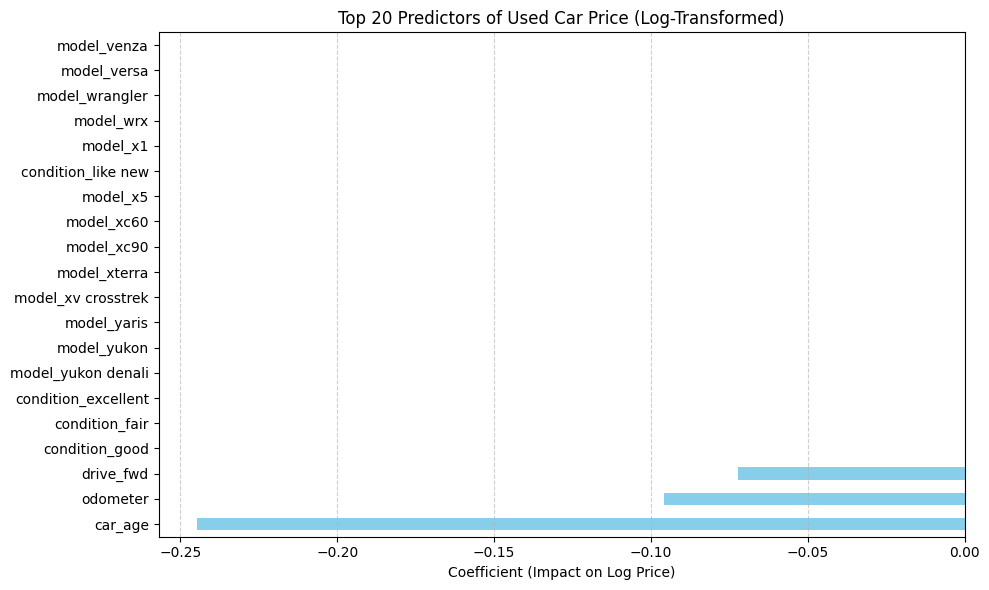

In [ ]:
# Plot top 20 predictors (by absolute impact on log price)
top_20 = coefficients_sorted.head(20)

plt.figure(figsize=(10, 6))
top_20.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Coefficient (Impact on Log Price)')
plt.title('Top 20 Predictors of Used Car Price (Log-Transformed)')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Sets a threshold for “non-zero”
threshold = 0.000001

nonzero_coefs = coefficients[coefficients.abs() > threshold].sort_values(key=abs, ascending=False)
print(nonzero_coefs)

car_age     -0.244642
odometer    -0.095972
drive_fwd   -0.072151
dtype: float64


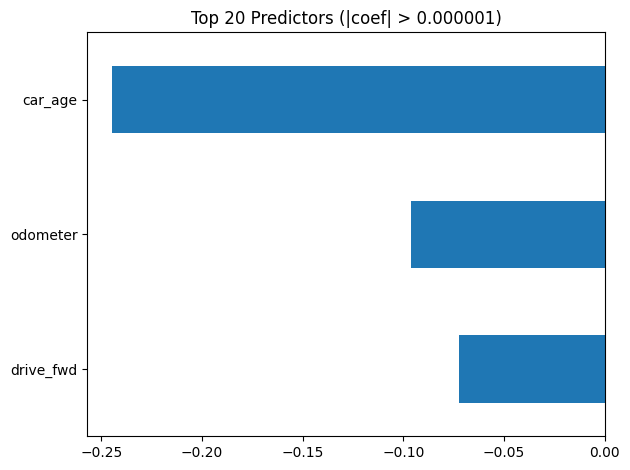

In [ ]:
nonzero_coefs.head(30).plot(kind='barh', title='Top 20 Predictors (|coef| > 0.000001)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
car_age_coef = coefficients.get('car_age', None)

if car_age_coef is not None:
    depreciation_rate = np.expm1(-car_age_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("car_age coefficient not found.")

Estimated average annual depreciation: 27.72%


In [ ]:
odometer_coef = coefficients.get('odometer', None)

if odometer_coef is not None:
    depreciation_rate = np.expm1(-odometer_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("odometer coefficient not found.")

Estimated average annual depreciation: 10.07%


In [ ]:
drive_fwd_coef = coefficients.get('drive_fwd', None)

if drive_fwd_coef is not None:
    depreciation_rate = np.expm1(-drive_fwd_coef)
    print(f"Estimated average annual depreciation: {depreciation_rate:.2%}")
else:
    print("drive_fwd coefficient not found.")

Estimated average annual depreciation: 7.48%


✅ No duplicate columns found.


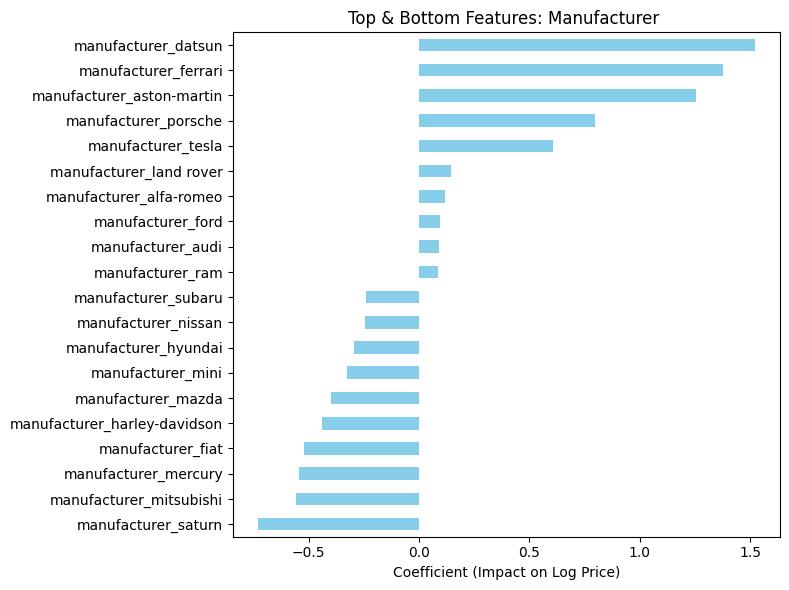

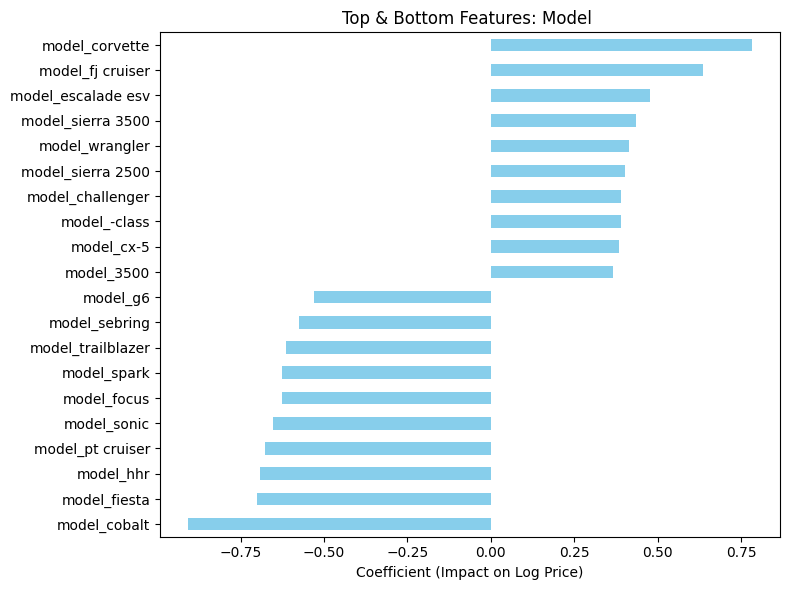

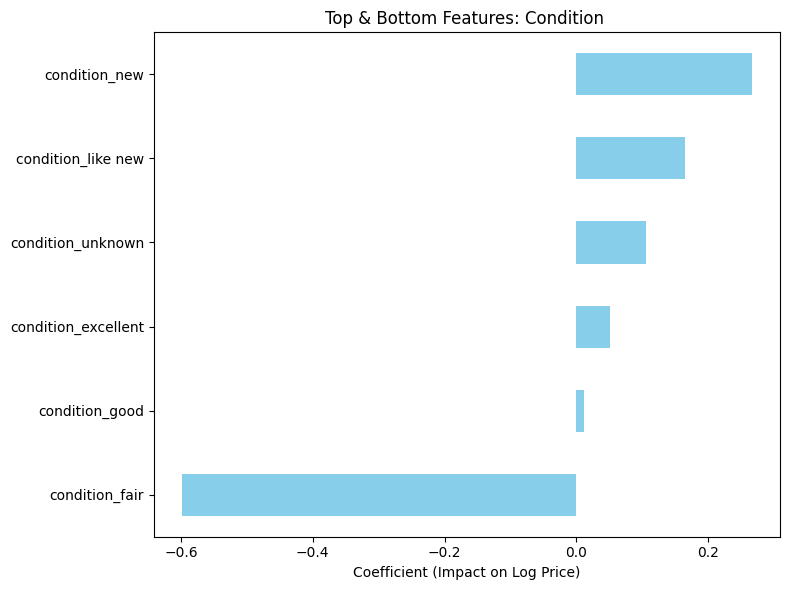

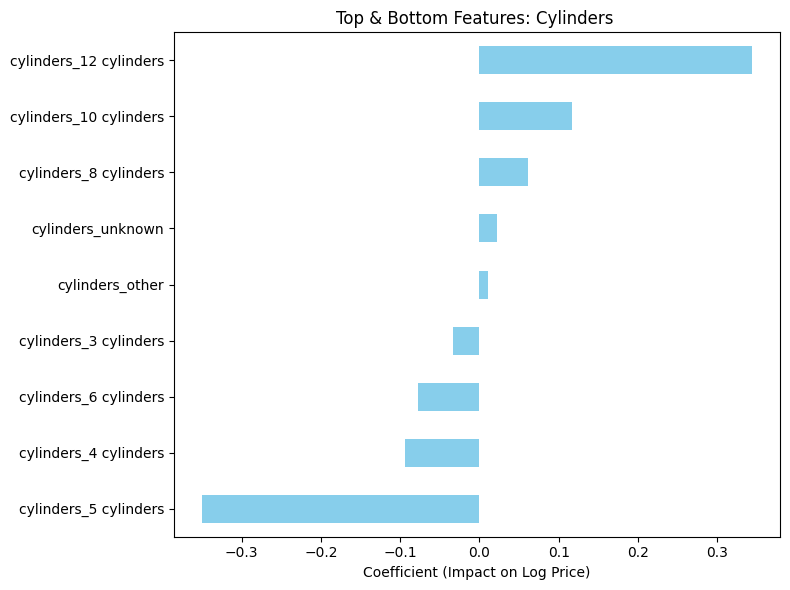

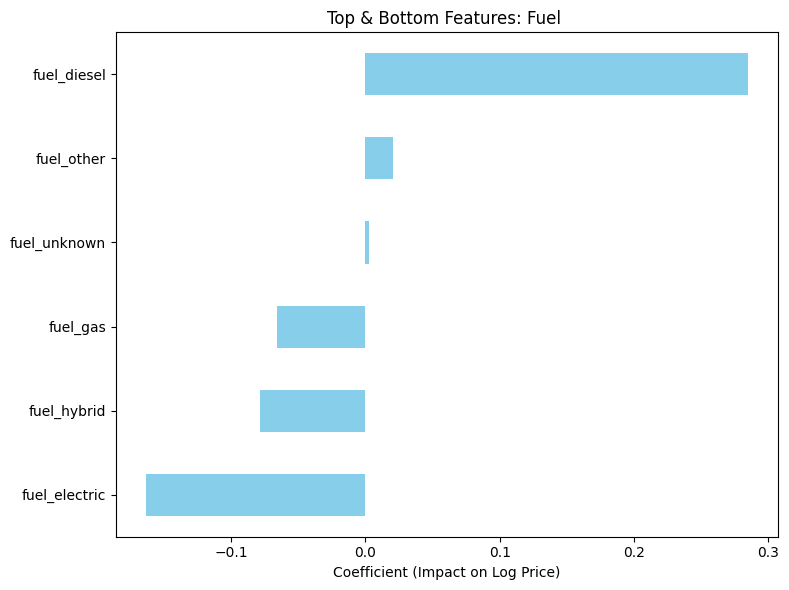

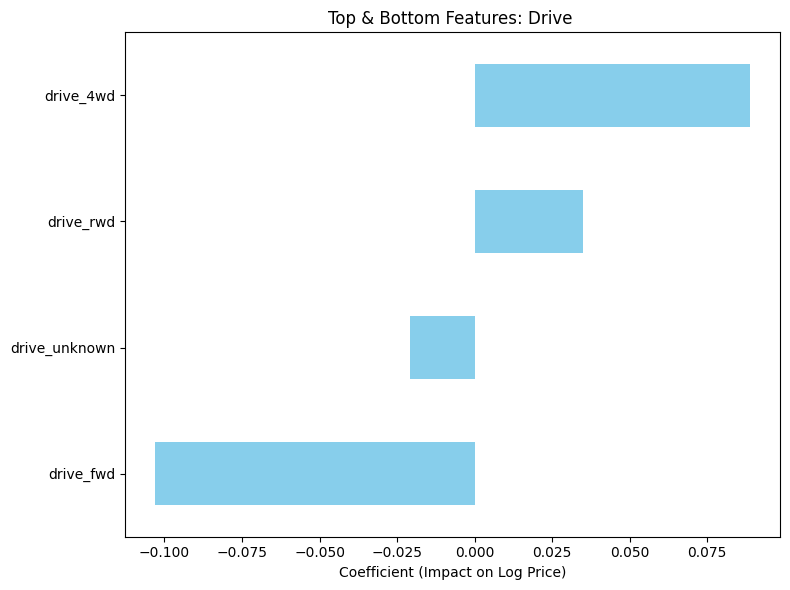

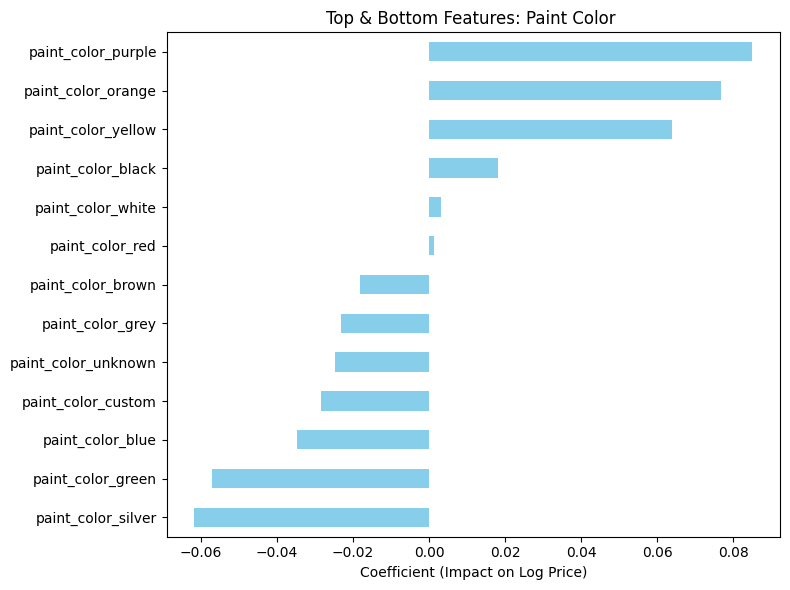

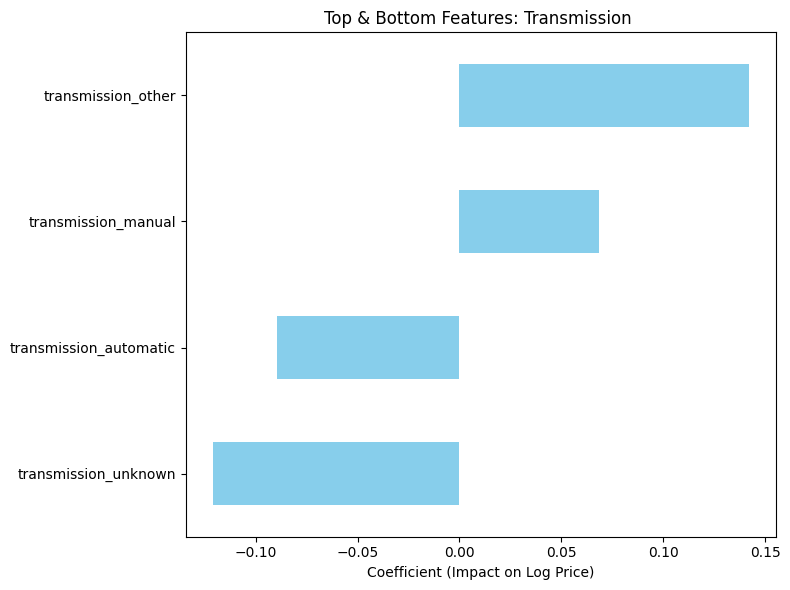

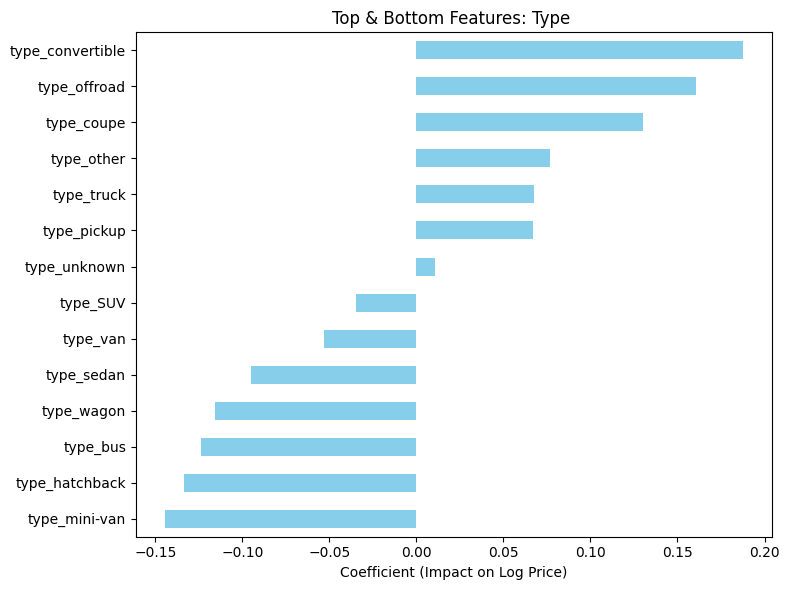

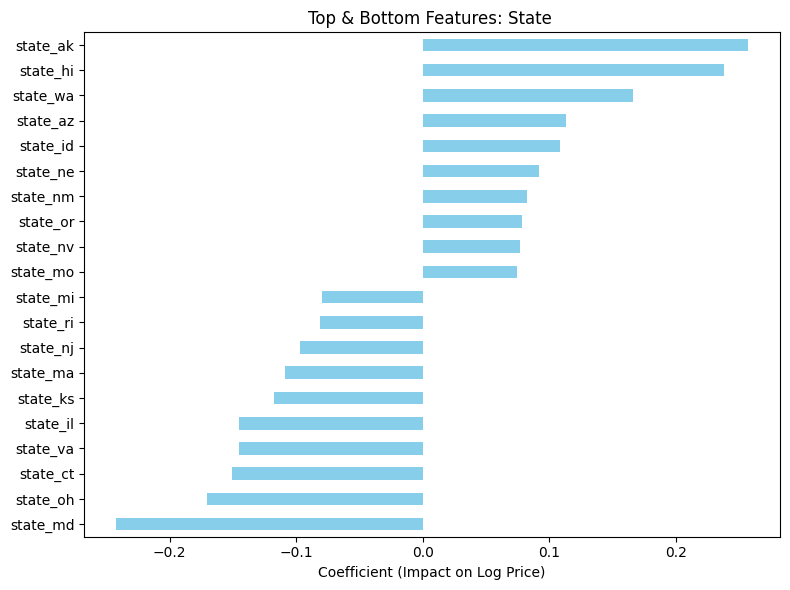

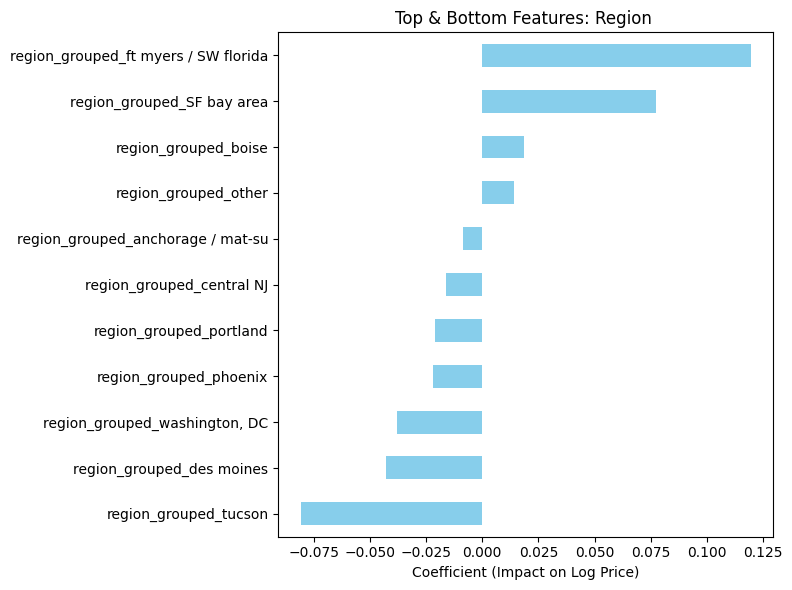

In [ ]:
# Drop duplicate columns, if any
duplicates = X.columns[X.columns.duplicated()].tolist()

if duplicates:
    print("Duplicate columns found:\n", duplicates)
    # Drop duplicate columns (keeping first occurrence)
    X = X.loc[:, ~X.columns.duplicated()]
    print(f"\nRemoved {len(duplicates)} duplicate columns.")
else:
    print("✅ No duplicate columns found.")

# Extract coefficients from Linear Regression
linear_model_trained = models['Linear Regression']
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', linear_model_trained)
])
pipeline_linear.fit(X_train, y_train)
feature_names = numerical_cols + list(pipeline_linear.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
linear_coefs = pd.Series(pipeline_linear.named_steps['regressor'].coef_, index=feature_names)

# Define feature group prefixes
group_prefixes = [
    'manufacturer_', 'model_', 'condition_', 'cylinders_', 'fuel_',
    'drive_', 'paint_color_', 'transmission_', 'type_', 'state_', 'region_'  # Adjusted from region_grouped_
]

# Plot top 10 and bottom 10 by group without duplicates
features_by_group = {}
for prefix in group_prefixes:
    group_coeffs = linear_coefs[linear_coefs.index.str.startswith(prefix)]
    if not group_coeffs.empty:
        sorted_group = group_coeffs.sort_values()
        if len(sorted_group) <= 20:
            top_bottom = sorted_group
        else:
            top_bottom = pd.concat([sorted_group.head(10), sorted_group.tail(10)]).drop_duplicates()
        features_by_group[prefix] = top_bottom

# Plotting
for prefix, series in features_by_group.items():
    plt.figure(figsize=(8, 6))
    series.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top & Bottom Features: {prefix.replace('_', ' ').title()}")
    plt.xlabel("Coefficient (Impact on Log Price)")
    plt.tight_layout()
    plt.show()


I set out to build a model to help a used car dealership understand what makes certain vehicles more valuable than others. After a significant amount of data cleaning and transformation, I evaluated three regression models: Linear, Ridge, and Lasso.

| Model                | RMSE       | R²         | CV R² (5-fold) |
| -------------------- | ---------- | ---------- | -------------- |
| Linear Regression    | 0.4325     | 0.6679     | 0.4544         |
| **Ridge Regression** | **0.4323** | **0.6681** | **0.4543**     |
| Lasso Regression     | 0.6221     | 0.3128     | 0.1878         |


Although Linear Regression performed almost identically to Ridge in terms of RMSE and R², I ultimately selected Ridge Regression for the final model due to its superior ability to handle high-dimensional, one-hot-encoded feature sets. Ridge also offers better generalization to unseen data, especially in situations with multicollinearity.

Key predictors of price included:

- Car Age: The biggest factor — cars lose about 27.7% of their value per year on average.

- Odometer: Mileage also drives price down, with an average annual depreciation of around 10.1%.

- Drive Type: Front-wheel-drive (FWD) slightly reduces value compared to AWD or RWD (~7.5% drop).

- Make & Model: Luxury brands (i.e., Ferrari, Aston-Martin) and popular models (i.e., Corvette) added significant value.

To clean the data:

- I removed extreme outliers like $0 listings and placeholder VINs.

- I grouped rare regions to prevent an explosion of meaningless one-hot-encoded features that introduced noise into the model.

Initially, I mistakenly kept both year and car_age in the dataset, which skewed results. I later corrected this by focusing only on car_age, which provided more interpretable output and aligned better with business expectations.

Feature Group Analysis with Linear Regression

While Ridge is ideal for production and prediction, I used Linear Regression to analyze the impact of feature groups more clearly.

I grouped features by type (i.e., model_, manufacturer_, paint_color_, transmission_) and visualized the top and bottom 10 features within each category. This revealed how specific brands, models, or characteristics affect resale value — insights that would be obscured by Ridge’s coefficient shrinkage.

For example:

- Manual transmissions and unique paint colors were often positively correlated with price.

- Certain makes and models (like Chevy Cobalt or Ford Fiesta) were negatively correlated with resale value.

This diagnostic analysis with Linear Regression gave me a deeper understanding of each feature’s isolated influence.

At this point, we do not believe earlier phases need revision, as the model performs well and provides insights directly aligned with the dealership’s goals.

This model is ready to support pricing recommendations and strategic inventory decisions.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.